# Data Preprocessing
> gathering data and creating a dataset

SWIMSEG is a public dataset hosted on github that contains 400 sky imager pictures. 

Let's make a Custom Unet that is `torch.jit.script`-able, to do so, we need to make the code very clean, without using the magic behind fastai's `SequentialEx` and removing the `Hooks` that are put on the encoder, and recover the shortcuts on the UNET by hand.

In this notebooks we will explore cloud public datasets and implement some basic deep learning pipelines
- One initial resource will be [WSISEG-Database](https://github.com/CV-Application/WSISEG-Database)

The database contains 400 uncropped whole sky images and corresponding labels. In these annotation images, cloud, clear sky and undefined area are marked with gray value 255, 100, 0 respectively.

 The original [paper](https://www.atmos-meas-tech.net/13/1953/2020/amt-13-1953-2020.pdf) that introduces the dataset.

We will first download the dataset and import the deep learning Libraries for the task.

In [2]:
import math
from pathlib import Path
import shutil
import csv

from types import SimpleNamespace
import wandb
from PIL import Image
import matplotlib.pyplot as plt

from dl_lib.utils import *

> Note: I have put a set of scripts on the `dl_lib` folder to make the code more readable. Includes some handy tools like `is_gpu`:

In [3]:
# %pip install wandb -Uqq

In [4]:
wandb.init(project='cloud-dataset',
          config={
              "dataset":'WSISEG-Database',
              "resize_to": [128, 256],
      })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tcapelle (use `wandb login --relogin` to force relogin)


In [5]:
config = wandb.config
config

{'dataset': 'WSISEG-Database', 'resize_to': [128, 256]}

In [6]:
# config=SimpleNamespace(dataset='WSISEG-Database',
#                        resize_to=[128, 256],
#                       )

## Log the Dataset to wandb
> upload and version the data we are going to use next

Let's grab the data from the WSISEG repo and resize images to desired sizes:

In [7]:
PATH = Path.cwd().parent 
DATASET_PATH = PATH / config.dataset
download_wsiseg(DATASET_PATH)
# get_wsiseg(PATH, sizes=config.resize_to)

Cloning repo WSISEG into /home/tcapelle/Documents/cloud_segmentation/WSISEG-Database


In [8]:
list(DATASET_PATH.iterdir())

[Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/whole sky images'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/README.md'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/.git'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/annotation')]

this dataset is pretty flawed (as always), we will fix some thing before uploading it to `wandb`.
- folder names with spaces is almost never desired
- If you look inside the folders, the images have no extension.

let's fix this:

In [9]:
def fix_dataset(path, image_folder_name='images', masks_folder_name='masks'):
    "Fix dataset filenames"
    image_path = (path/'whole sky images').rename(path/image_folder_name)
    annotation_path = (path/'annotation').rename(path/masks_folder_name)
    print('Fixing image extensions')
    for folder in [image_path, annotation_path]:
        for im in folder.iterdir():
            if not im.name.endswith('.png'):
                im.rename(im.with_suffix('.png'))
    
    print('delete .git folder')
    shutil.rmtree(path/'.git')

In [10]:
fix_dataset(DATASET_PATH)

Fixing image extensions
delete .git folder


## 🚀 Let's log our first version of the dataset:

In [11]:
def upload_dataset(dataset_path: Path, metadata={}, description='initial dataset'):
    "Upload our clean up initial version of the dataset"
    artifact_dataset = wandb.Artifact(name=config.dataset, 
                                      type='dataset', 
                                      metadata=metadata,
                                      description=description)
    
    #upload folders and files insidet `dataset_path`
    for f in dataset_path.iterdir():
        if f.is_dir():
            artifact_dataset.add_dir(f, name=f.name)
        else:
            artifact_dataset.add_file(f)
    return wandb.run.use_artifact(artifact_dataset)

In [12]:
artifact_dataset = upload_dataset(DATASET_PATH)

wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/masks)... Done. 0.1s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images)... Done. 0.1s


let's look at the images

In [13]:
image_path = DATASET_PATH/f'images'
mask_path = DATASET_PATH/f'masks'

In [14]:
files = list(image_path.iterdir())
files[0:5]

[Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images/ASC100-1006_264.png'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images/ASC100-1006_191.png'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images/ASC100-1006_314.png'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images/ASC100-1006_392.png'),
 Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images/ASC100-1006_270.png')]

Let's take a look at one image:

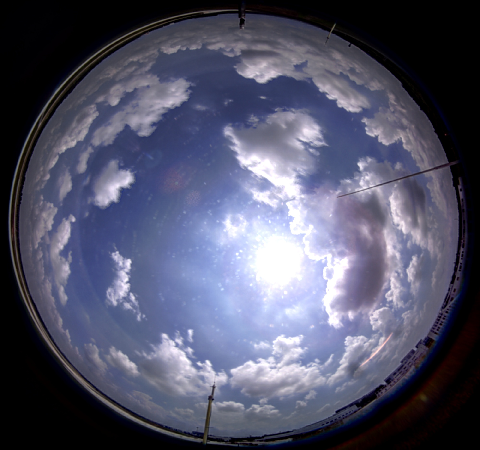

In [15]:
def load_image(fn, mode=None):
    "Open and load a `PIL.Image` and convert to `mode`"
    im = Image.open(fn)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im


im = load_image(files[0])
im

In [16]:
im.shape

(450, 480)

In [17]:
list(mask_path.iterdir())[0]

Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/masks/ASC100-1006_264.png')

The masks are called identically but place on the respective `masks` folder

In [18]:
def label_func(fn): 
    folder = fn.parent.name.replace('images', 'masks')
    return (fn.parent.parent/folder)/fn.name

In [20]:
def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL image on `ax`."
    if figsize is None: 
        figsize = (6,6)
    if ax is None: 
        _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: 
        ax.set_title(title)
    ax.axis('off')
    return ax

<AxesSubplot:>

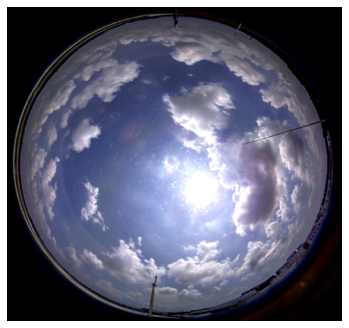

In [21]:
show_image(im)

In [22]:
def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: 
        ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: 
        titles = [None]*len(ims)
    axs = plt.subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

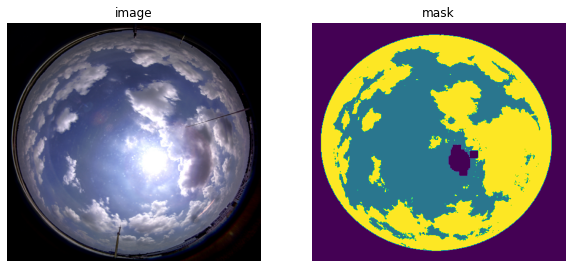

In [23]:
mask = load_image(label_func(files[0]))
show_images([im, mask], figsize=(10,5), titles=['image', 'mask'])

## Split
> Let's split the dataset on train/valid

We will use the first 340 images as trianing and the last 60 as validation. We will save a `csv` file with this split. We could actually move then and create a folder hierarchy `train/images/...` and `valid/images/...`.

In [24]:
n_train = 340
len(files)

400

In [25]:
with open(DATASET_PATH/'train.csv', 'w') as f:
    data = csv.writer(f)
    for line in files[0:n_train]:
        data.writerow([str(line.relative_to(Path.cwd().parent))])
        
with open(DATASET_PATH/'valid.csv', 'w') as f:
    data = csv.writer(f)
    for line in files[n_train:]:
        data.writerow([str(line.relative_to(Path.cwd().parent))])

In [26]:
for f in ['train.csv', 'valid.csv']:
    artifact_dataset.add_file(DATASET_PATH/f)

#to pipe the changes in 
wandb.run.use_artifact(artifact_dataset)

ValueError: Can't add to finalized artifact.

## Resizing the images

In [ ]:
re